In [1]:
import os, sys
from datetime import datetime, timedelta,date
import pandas as pd
from IPython.display import display
import xarray as xr
from matplotlib import dates as mdates
import seaborn as sns
import learning_lidar.generation.generation_utils as gen_utils
from scipy.stats import ks_2samp
from learning_lidar.utils import utils, xr_utils, vis_utils, proc_utils, global_settings as gs
vis_utils.set_visualization_settings()
TIMEFORMAT = mdates.DateFormatter(r'%H')
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.mixture import  BayesianGaussianMixture as BayesGMM
from pytictoc import TicToc
import sklearn
import learning_lidar.dataseting.dataseting_utils as ds_utils
from pathlib import Path
import platform
import learning_lidar.generation.valid_utils  as valid_utils
import glob

# Analyse finer PollyNet retrievals
### 1. Run Settings

In [2]:
# Data source info
station_name='haifa'
station = gs.Station(station_name)
day_date = datetime(2017,10,2)
daily_times = station.calc_daily_time_index(day_date)
wavelength = 532

# Paths
TGRS_folder = os.path.abspath(os.path.join(gs.PKG_ROOT_DIR ,"..","E","TGRS_GMM_appendix")) if \
    (sys.platform in ['linux', 'ubuntu']) else \
    os.path.abspath(os.path.join(gs.PKG_ROOT_DIR ,"..",'TGRS_GMM_appendix'))
figs_folder = os.path.join(TGRS_folder,'figures')
model_base_name = 'sklearn_GMM_Model'
models_folder = os.path.join(TGRS_folder,'models')
csv_models = os.path.join(models_folder,'models.csv')
name_str = f"TGRS_TROPOS_{day_date.strftime('%Y-%m-%d')}_profiles"
table_name = name_str+"_info.csv"
profiles_ds_name = name_str+".nc"

# Flags
LOAD_MODEL = True
SAMPLE_BETA = False
GEN_PROFILES = False # True - crate and save the profiles; False - upload previous generated data
SAVE_FIG = True
LOAD_CLIB_CSV = False

# Global print settings
FORMAT_FIG = 'svg' # 'svg'
figsize=(8, 5)  # prev: (12,5)
max_height = 15 # km
height_slice=slice(0,max_height)
sns.set_context('talk')

### 2. Show daily range corrected signal $\rm P^2R$


In [3]:
month_folder = utils.get_month_folder_name(station.lidar_dataset, day_date)
file_name = xr_utils.get_prep_dataset_file_name(station, day_date, data_source='lidar', file_type='all')
if os.path.isdir(month_folder):
    raw_daily_path = glob.glob(os.path.join(month_folder, file_name))[0]
    raw_daily_path
    raw_daily_ds = xr_utils.load_dataset(raw_daily_path)

    raw_daily_ds.range_corr.attrs= {'info': 'Raw Range Corrected Lidar Signal',
                                             'long_name': r'$\rm R^2P$',
                                             'name': 'range_corr',
                                             'units': r'$\rm photons \cdot km^2$',
                                             'location': 'Haifa'}

    valid_utils.plot_daily_profile_for_publish(raw_daily_ds.range_corr.sel(Wavelength=532),
                                height_slice=height_slice, figsize=(8, 5),
                                folder_name=figs_folder,format_fig=FORMAT_FIG,
                                save_fig=SAVE_FIG, threshold=300)

### 3. Load calibration csv from TROPOS or Extract profiles data required for analysis


In [4]:
# Load dataset or generate new dataset from Pollynet outputs
if GEN_PROFILES:
    if LOAD_CLIB_CSV:
        # Load calibration dataset # Extract the data parameters of the data from pollynet '+lidar_calibration_constant.csv'
        pollynet_calib_path = 'pollyxt_tropos_calibration_lidar_calibration_constant.csv'
        polly_calib = pd.read_csv(os.path.join(TGRS_folder, pollynet_calib_path))
        polly_calib['cali_start_time']= pd.to_datetime(polly_calib['cali_start_time'])
        polly_calib['cali_stop_time']= pd.to_datetime(polly_calib['cali_stop_time'])
        polly_calib['date'] = polly_calib['cali_start_time'].dt.date
        method = 'Klett_Method'
        telescope = 'far_range'
        df_calib =  polly_calib[polly_calib.date == day_date.date()][polly_calib.wavelength ==wavelength][polly_calib.telescope==telescope][polly_calib.cali_method==method]
        df_calib = ds_utils.add_profiles_values(df_calib, station, day_date, file_type='profiles')
        df_calib = df_calib.rename({'liconst': 'LC', 'uncertainty_liconst': 'LC_std', 'matched_nc_profile': 'profile_path',
                   'cali_start_time':'start_time_period','cali_stop_time':'end_time_period'},
                            axis='columns')
        display(df_calib)
    else:
        # Extract profiles data
        df_calib = None
    daily_beta_chan, daily_datset_df = valid_utils.daily_backscatter_from_profiles(day_date=day_date, station=station, df_calib=df_calib, wavelength=532)

    # save profiles info and values
    xr_utils.save_dataset(dataset=daily_beta_chan,folder_name=TGRS_folder,nc_name=profiles_ds_name)
    daily_datset_df.to_csv(os.path.join(TGRS_folder,table_name))
else:
    # upload profiles info and values
    daily_beta_chan = xr_utils.load_dataset(os.path.join(TGRS_folder,profiles_ds_name))
    daily_datset_df = pd.read_csv(os.path.join(TGRS_folder,table_name))

valid_times = [datetime.strptime(str(t),'%Y-%m-%d %H:%M:%S') for t in daily_datset_df[daily_datset_df['valid']]['mid_time_period']]

display(daily_beta_chan)

<xarray.Dataset>
Dimensions:      (Time: 2880, Wavelength: 1, Height: 3000)
Coordinates:
  * Time         (Time) datetime64[ns] 2017-10-02 ... 2017-10-02T23:59:30
  * Height       (Height) float64 0.07875 0.08622 0.09369 ... 22.47 22.48 22.49
  * Wavelength   (Wavelength) int32 532
Data variables:
    beta         (Wavelength, Height, Time) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    date         datetime64[ns] 2017-10-02
    beta_ratio   (Wavelength, Height, Time) float32 nan nan nan ... nan nan nan
    ratio        (Wavelength, Height, Time) float32 nan nan nan ... nan nan nan
    interp_beta  (Wavelength, Height, Time) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    beta_gmm1    (Wavelength, Height, Time) float32 2.942e-05 3.094e-05 ... 0.0
    beta_gmm2    (Wavelength, Height, Time) float32 2.379e-05 2.575e-05 ... 0.0
    beta_gmm3    (Wavelength, Height, Time) float32 2.362e-05 2.552e-05 ... 0.0
Attributes:
    location:  Haifa

In [5]:
if LOAD_CLIB_CSV:
    da = polly_calib.set_index(['cali_start_time','wavelength','cali_method','id']).to_xarray()
    time_slice= slice(day_date,day_date+timedelta(hours=24))
    da.sel(wavelength=wavelength, cali_start_time=time_slice).plot.scatter(y='liconst' ,x = 'cali_start_time', hue='cali_method', figsize=(15,7), s=2)
    plt.show()

### 4. Show daily aerosol coefficients

/home/addalin/learning_lidar/learning_lidar/generation/valid_utils.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


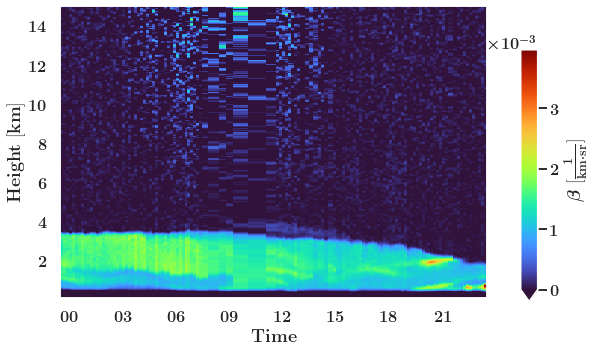

('/home/addalin/E/TGRS_GMM_appendix/figures/Daily estimated aerosol backscatter by PollyNet Processing Chain, Tropos - 2017-10-02.svg',
 <Figure size 576x360 with 2 Axes>,
 <AxesSubplot:xlabel='\\textbf{Time}', ylabel='\\textbf{Height} [$\\rm \\textbf{km}$]'>)

In [6]:
valid_utils.plot_daily_profile_for_publish(daily_beta_chan.sel(Time=valid_times).beta,
                               height_slice=height_slice,  #, threshold= 2.5e-3 )
                               figsize=figsize, save_fig=SAVE_FIG,
                               folder_name=figs_folder, format_fig=FORMAT_FIG)

### 5. Set and apply ratio to remove nonsense values, e.g., due to sun scatter.
### In addition removing negative values. Note that beta ratio will be used as weights for sampling, therefore, values must be positive.

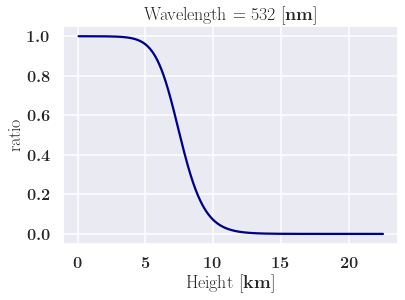

/home/addalin/learning_lidar/learning_lidar/generation/valid_utils.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


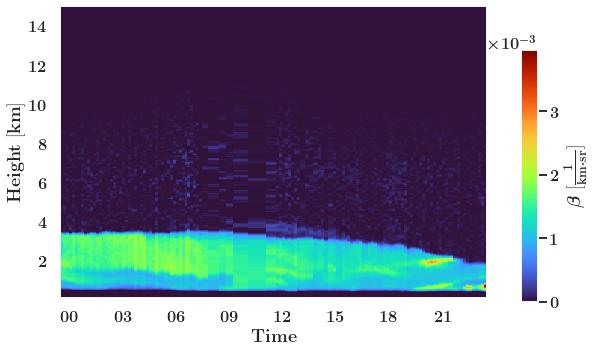

Range of backscatter coefficients in heights of slice(0, 15, None)[km] for orig beta:[-0.0016, 0.0040], after ratio: [0.0000, 0.0040]


In [7]:
sub_beta= daily_beta_chan.sel(Time=valid_times)

if GEN_PROFILES:
    # Set ratio
    ratio = xr.apply_ufunc(lambda x :gen_utils.sigmoid(daily_beta_chan.Height,x0=7,A=2,v=1.5)-1,
                           daily_beta_chan.Height, keep_attrs=True).\
        broadcast_like(sub_beta.beta).assign_attrs({'info': "Height-dependent ratio to apply on backscatter to reduce nonsense values",
                                                                  'name': 'ratio'})
    # Apply ratio
    beta_ratio = xr.apply_ufunc(lambda x,ratio: x*ratio,
                                sub_beta.beta.clip(min = gs.eps),
                                ratio,keep_attrs=True).fillna(gs.eps)
    beta_ratio.attrs['info']+=' - followed by ratio to reduce nonsense values.'
    # Add data arrays to  daily_beta_chan and save
    daily_beta_chan = daily_beta_chan.assign(beta_ratio=beta_ratio, ratio=ratio)
    xr_utils.save_dataset(dataset=daily_beta_chan,folder_name=TGRS_folder,nc_name=profiles_ds_name)
else:
    ratio = daily_beta_chan.ratio
    beta_ratio = daily_beta_chan.sel(Wavelength = wavelength).beta_ratio

# Plot ration and beta_ratio
ratio.mean(dim='Time').plot()
plt.show()
valid_utils.plot_daily_profile_for_publish(beta_ratio.sel(Time=valid_times), height_slice=height_slice,
                               figsize=figsize, save_fig=SAVE_FIG,
                               folder_name=figs_folder, format_fig=FORMAT_FIG)


print(f"Range of backscatter coefficients in heights of {height_slice}[km] for orig beta:"
      f"[{sub_beta.sel(Height= height_slice).beta.min().item():.4f}, {sub_beta.sel(Height= height_slice).beta.max().item():.4f}], "
      f"after ratio: [{beta_ratio.sel(Height= height_slice).min().item():.4f}, {beta_ratio.sel(Height= height_slice).max().item():.4f}]")

### 6. Time interpolated backscatter

/home/addalin/learning_lidar/learning_lidar/generation/valid_utils.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


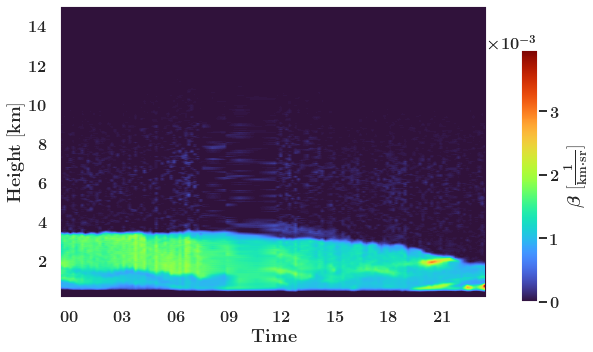

('/home/addalin/E/TGRS_GMM_appendix/figures/Time interpolation of estimated aerosol backscatter profiles by PollyNet Processing Chain, Tropos - 2017-10-02.svg',
 <Figure size 576x360 with 2 Axes>,
 <AxesSubplot:xlabel='\\textbf{Time}', ylabel='\\textbf{Height} [$\\rm \\textbf{km}$]'>)

In [8]:
if GEN_PROFILES:
    interp_beta =  beta_ratio.interp(Time=daily_times).fillna(0.0) # sub_beta.beta.interp(Time=daily_times).fillna(0.0)
    interp_beta.attrs['info'] = 'Time interpolation of estimated aerosol backscatter profiles by PollyNet Processing Chain, Tropos'
    daily_beta_chan = daily_beta_chan.assign(interp_beta=interp_beta)
    xr_utils.save_dataset(dataset=daily_beta_chan,folder_name=TGRS_folder,nc_name=profiles_ds_name)
else:
    interp_beta = daily_beta_chan.interp_beta.sel(Wavelength=wavelength)


valid_utils.plot_daily_profile_for_publish(daily_beta_chan.interp_beta, height_slice=height_slice,
                               figsize=figsize, save_fig=SAVE_FIG,
                               folder_name=figs_folder, format_fig=FORMAT_FIG)



/home/addalin/learning_lidar/learning_lidar/generation/valid_utils.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


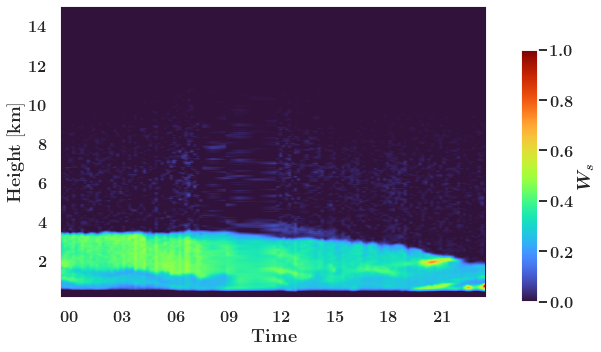

('/home/addalin/E/TGRS_GMM_appendix/figures/Grid sample weights - 2017-10-02.svg',
 <Figure size 576x360 with 2 Axes>,
 <AxesSubplot:xlabel='\\textbf{Time}', ylabel='\\textbf{Height} [$\\rm \\textbf{km}$]'>)

In [9]:
norm_beta_interp = xr.apply_ufunc(lambda x: proc_utils.normalize(x) , interp_beta.clip(min=gs.eps), keep_attrs=True)
norm_beta_interp.attrs={'name':'samples weight', 'long_name':r'$W_s$',
                        'info': 'Grid sample weights'}
valid_utils.plot_daily_profile_for_publish(norm_beta_interp, height_slice=height_slice,
                               figsize=figsize, save_fig=SAVE_FIG,
                               folder_name=figs_folder, format_fig=FORMAT_FIG)

### 7. Plot contours

In [10]:
USE_CONTOURS = False
if USE_CONTOURS:
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15, 5))
    CS = xr.plot.contour(daily_beta_chan.sel(Wavelength = 532, Height=slice(0,15)).interp_beta,
                    add_labels = True, add_colorbar =True, ax= ax,cmap= 'turbo')
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_rasterization_zorder(-10)
    ax.xaxis.set_major_formatter(TIMEFORMAT)
    ax.xaxis.set_tick_params(rotation=0)
    #
    ax.set_ylabel(ax.get_ylabel().replace("Height", r'\textbf{Height}'))
    ax.set_xlabel(ax.get_xlabel().replace("Time", r'\textbf{Time}'))
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("left")
    if SAVE_FIG:
        #if folder_name is None:
        folder_name = figs_folder #os.path.join(os.path.abspath(os.path.curdir),'figures')
        stitile = f"Contours of beta for {day_date.strftime('%Y-%m-%d')}"
        fig_path = vis_utils.save_fig(fig, fig_name=stitile,
                                           folder_name=folder_name,
                                           format_fig=FORMAT_FIG)
    plt.show()
    levels = CS.levels
    print(f"Num levels ={len(levels)}  at values: {levels}")

    # set levels values (min_val, max_val) for each level.
    min_vals = levels[0:-1][0::1]
    max_vals = min_vals[1::1].tolist()
    max_vals.append(daily_beta_chan.sel(Wavelength = 532, Height=slice(0,15) ).interp_beta.max().item())
    print('min vals:',min_vals,' max vals:',max_vals)

### 8. Set grid for sampling $\beta$ after ratio

In [11]:
# scaling time dimension, since the BW currently is equal to both dimensions (in sklearn, not sure regardig scipy)
SCALE_TIME = True
if SCALE_TIME:
    bw_height = 0.1 # [km]
    bw_time = 300 # [sec] --> 10 min = 600 sec
    scale_time = bw_time/bw_height
else:
    scale_time = 1.0
    bw_height =''
    bw_time =''

beta_ratio.sel(Time=valid_times)

# Set xy valid locations (valid are positions of data retrieved by TROPOS, it is a subset of the full grid):
y = daily_beta_chan.sel(Height= height_slice).Height.values  # [km]
x_valid = np.array([(t-day_date).seconds for t in valid_times])/scale_time # [seconds]

X_valid,Y_valid = np.meshgrid(x_valid, y, indexing='xy')
XYg_valid = np.stack([X_valid, Y_valid])


# Set full xy grid:
timeIndx = daily_times
x_full = np.array([(t-day_date).seconds for t in timeIndx])/scale_time  # [seconds]
step_x = 1
step_y = 1
X_full,Y_full = np.meshgrid(x_full[::step_x], y[::step_y], indexing='xy')
XYg_full = np.stack([X_full, Y_full])


# Create time samples every 10 minutes to fill up missing values in x_valid

time_intep_sample = timeIndx[9::20]
x_samp = np.array([(t-day_date).seconds for t in time_intep_sample])/scale_time
X_samp,Y_samp = np.meshgrid(x_samp[::step_x], y[::step_y], indexing='xy')
XYg_samp = np.stack([X_samp, Y_samp])
# TODO: test that x_isamples is completing x_valid i.e., try x_isamples[0:10]-x_valid[0:10]

### 9. Sample $\beta$

/home/addalin/learning_lidar/learning_lidar/generation/valid_utils.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


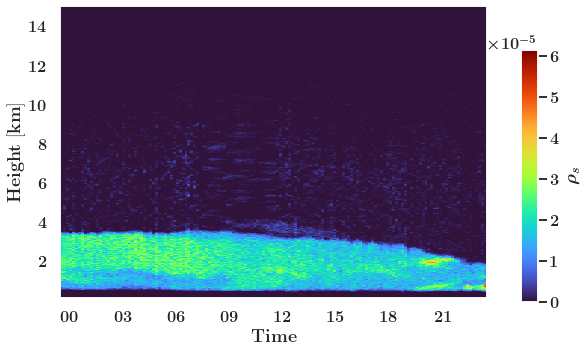

('/home/addalin/E/TGRS_GMM_appendix/figures/2D normalized histogram of init_samples_norm_beta, sample number 2877120 - 2017-10-02.png',
 <Figure size 576x360 with 2 Axes>,
 <AxesSubplot:xlabel='\\textbf{Time}', ylabel='\\textbf{Height} [$\\rm \\textbf{km}$]'>)

In [12]:
source_name = f"init_samples_norm_beta" # or "init_samples"
samples_fname = os.path.join(TGRS_folder, f'{source_name}.csv')
weights_beta = norm_beta_interp if 'norm' in source_name else interp_beta
if SAMPLE_BETA:
    total_samples = len(time_intep_sample)*len(y)*10
    n_iter = len(time_intep_sample)*10
    samples_df = valid_utils.sample_grid_weights(XY_grid = XYg_samp,
                          weights= weights_beta.sel(Time=time_intep_sample,Height= height_slice),
                          n_iter=n_iter,  total_samples = total_samples)
    samples_df.to_csv(samples_fname, index=False)
else:
    samples_df = pd.read_csv(samples_fname)


hist_2D,(H, yedges, xedges) = valid_utils.calc_2D_hist(XY_grid = XYg_samp,samples_df=samples_df,weights= interp_beta.sel(Time=time_intep_sample,Height= height_slice),
                       sample_source_name=source_name, norm_hist=True)
valid_utils.plot_daily_profile_for_publish(hist_2D, figsize=figsize, save_fig=SAVE_FIG, folder_name=figs_folder)

/home/addalin/learning_lidar/learning_lidar/generation/valid_utils.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


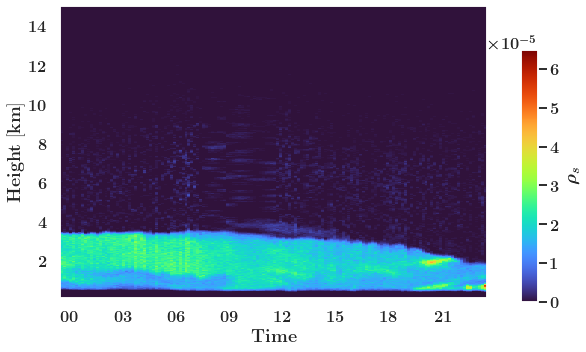

('/home/addalin/E/TGRS_GMM_appendix/figures/2D normalized histogram of extend_samples_norm_beta, sample number 17262720 - 2017-10-02.svg',
 <Figure size 576x360 with 2 Axes>,
 <AxesSubplot:xlabel='\\textbf{Time}', ylabel='\\textbf{Height} [$\\rm \\textbf{km}$]'>)

In [13]:
source_name = f"extend_samples_norm_beta" # or "extend_samples"
samples_fname = os.path.join(TGRS_folder, f'{source_name}.csv')
weights_beta = norm_beta_interp if 'norm' in source_name else interp_beta
if SAMPLE_BETA:
    total_samples *= 5
    n_iter *= 5
    samples1_df = valid_utils.sample_grid_weights(XY_grid = XYg_samp,
                           weights= weights_beta.sel(Time=time_intep_sample,Height= height_slice),
                           n_iter=n_iter,  total_samples = total_samples)
    samples_extend_df = pd.concat([samples_df, samples1_df])
    samples_extend_df.to_csv(samples_fname, index=False)
else:
    samples_extend_df = pd.read_csv(samples_fname)

hist_2D_more,_ = valid_utils.calc_2D_hist(XY_grid = XYg_samp,samples_df=samples_extend_df,
                              weights= interp_beta.sel(Time=time_intep_sample,Height= height_slice),
                              sample_source_name=source_name, norm_hist=True)
valid_utils.plot_daily_profile_for_publish(hist_2D_more, figsize=figsize, folder_name=figs_folder, save_fig=SAVE_FIG, threshold= 6.5e-5, format_fig='svg')

In [14]:
model1_fname = os.path.join(models_folder,f"{model_base_name}_1.pkl")
if LOAD_MODEL:
    # load model
    print("Load trained gmm model")
    with open(model1_fname, 'rb') as f:
        gmm = pickle.load(f)

else:
    gmm = BayesGMM(n_components=31,covariance_type="full",verbose=2,
                  tol=0.0001,reg_covar= 1e-7,max_iter=600, # increase max_iter
                  n_init=1,  init_params='k-means++') # mean_prior=(X[0,:].mean(),0.2)) # "tied", "diag", "full"

    print('Start GMM fit')
    tic_fit=TicToc()
    tic_fit.tic()
    gmm.fit(samples_df.values)#(samples.T)
    tic_fit.toc()

    # save model
    with open(model1_fname,'wb') as f:
        pickle.dump(gmm,f)
gmm

Load trained gmm model


BayesianGaussianMixture(init_params='k-means++', max_iter=600, n_components=31,
                        reg_covar=1e-07, tol=0.0001, verbose=2)

### 11. Calculate $\beta_{\rm GMM}$ using log-likelihood scores of GMM model on the grid

calculate log-likelihood of gmm for the input grid
Elapsed time is 18.115082 seconds.


/home/addalin/learning_lidar/learning_lidar/generation/valid_utils.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


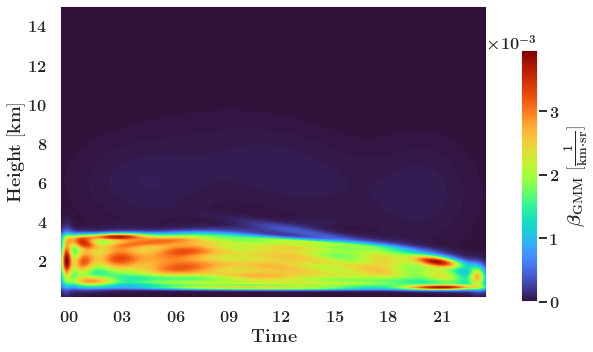

('/home/addalin/E/TGRS_GMM_appendix/figures/daily_beta_sklearn_GMM_Model_1.png',
 <Figure size 576x360 with 2 Axes>,
 <AxesSubplot:xlabel='\\textbf{Time}', ylabel='\\textbf{Height} [$\\rm \\textbf{km}$]'>)

In [15]:
beta_gmm1_da = valid_utils.calc_beta_from_gmm( gmm = gmm, XY_grid= XYg_full, gmm_name='gmm1',
                   orig_beta = daily_beta_chan.beta,
                   timeIndx= timeIndx, height_slice=height_slice, wavelength=wavelength)
fname = f"daily_beta_{(os.path.split(model1_fname)[1]).split('.pkl')[0]}"
valid_utils.plot_daily_profile_for_publish(beta_gmm1_da.sel(Time= timeIndx),
                               height_slice=height_slice, figsize=figsize, fname=fname,
                               folder_name=figs_folder, save_fig=SAVE_FIG)

In [16]:
model2_fname = os.path.join(models_folder,f"{model_base_name}_2_extend_samples.pkl")
if LOAD_MODEL:
    # load model
    print("Load trained gmm model")
    with open(model2_fname, 'rb') as f:
        gmm2 = pickle.load(f)

else:
    gmm2 = sklearn.clone(gmm)
    tic_fit=TicToc()
    tic_fit.tic()
    gmm2.fit(samples_extend_df.values)
    tic_fit.toc()

    # save model
    gmm2.warm_start= True
    print('Continue GMM fit on more samples')
    with open(model2_fname,'wb') as f:
        pickle.dump(gmm2,f)
gmm2

Load trained gmm model


BayesianGaussianMixture(init_params='k-means++', max_iter=600, n_components=31,
                        reg_covar=1e-07, tol=0.0001, verbose=2,
                        warm_start=True)

calculate log-likelihood of gmm for the input grid
Elapsed time is 16.587664 seconds.


/home/addalin/learning_lidar/learning_lidar/generation/valid_utils.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


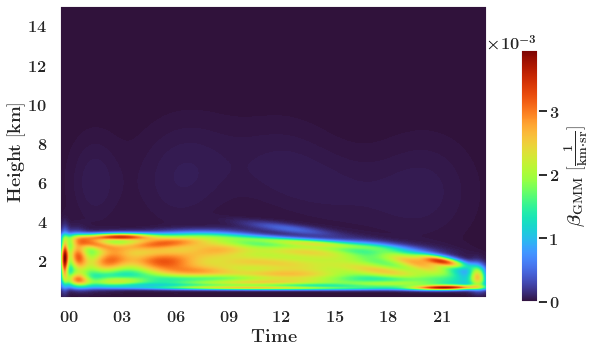

('/home/addalin/E/TGRS_GMM_appendix/figures/daily_beta_sklearn_GMM_Model_2_extend_samples.png',
 <Figure size 576x360 with 2 Axes>,
 <AxesSubplot:xlabel='\\textbf{Time}', ylabel='\\textbf{Height} [$\\rm \\textbf{km}$]'>)

In [17]:
beta_gmm2_da = valid_utils.calc_beta_from_gmm( gmm = gmm2, XY_grid= XYg_full,gmm_name='gmm2',
                   orig_beta = daily_beta_chan.beta,
                   timeIndx= timeIndx, height_slice=height_slice, wavelength=wavelength)
fname = f"daily_beta_{(os.path.split(model2_fname)[1]).split('.pkl')[0]}"
valid_utils.plot_daily_profile_for_publish(beta_gmm2_da.sel(Time= timeIndx),
                               fname=fname, folder_name=figs_folder,
                               height_slice=height_slice,
                               figsize=figsize, save_fig=SAVE_FIG)

### continue GMM2 on extended dataset with higher reg_covar and tol to check convergency

In [18]:
LOAD_MODEL = True
CONT_GMM2 = True
if CONT_GMM2:
    db_name = 'extended' # 'extended'
    samples = samples_df if db_name=='initial' else samples_extend_df
    cur_iter = gmm2.max_iter
    reg_covar = gmm2.reg_covar*10
    tol = gmm2.tol*10
    model3_fname = os.path.join(models_folder,f"{model_base_name}_3_{db_name}_"
                                              f"samples_iter_{cur_iter}_reg_cov_{reg_covar:.1e}_tol_{tol:.1e}.pkl")
    if LOAD_MODEL:
        # load model
        print("Load trained gmm model")
        with open(model3_fname, 'rb') as f:
            gmm3 = pickle.load(f)
    else:
        gmm3 = sklearn.clone(gmm2)
        gmm3.reg_cov = reg_covar
        gmm3.tol = tol
        print(f'Continue GMM fit on from iteration {cur_iter} on {db_name} samples,'
              f'\nupdate reg_cov to {reg_covar:.1e} and tol to {tol:.1e} ')
        tic_fit=TicToc()
        tic_fit.tic()
        gmm3.fit(samples.values)
        tic_fit.toc()
        # save model
        with open(model3_fname,'wb') as f:
            pickle.dump(gmm3,f)
gmm3

Load trained gmm model


BayesianGaussianMixture(init_params='k-means++', max_iter=600, n_components=31,
                        reg_covar=1e-07, verbose=2, warm_start=True)

calculate log-likelihood of gmm for the input grid
Elapsed time is 16.508163 seconds.


/home/addalin/learning_lidar/learning_lidar/generation/valid_utils.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


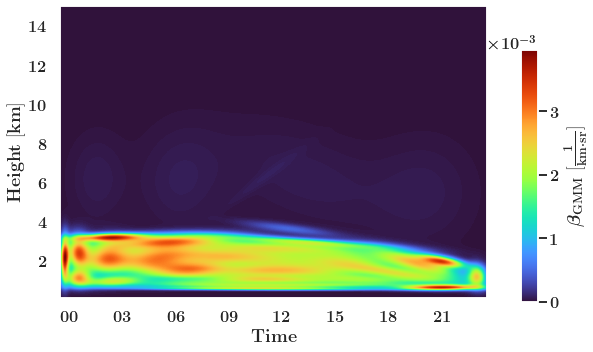

('/home/addalin/E/TGRS_GMM_appendix/figures/daily_beta_sklearn_GMM_Model_3_extended_samples_iter_600_reg_cov_1_0e-06_tol_1_0e-03.png',
 <Figure size 576x360 with 2 Axes>,
 <AxesSubplot:xlabel='\\textbf{Time}', ylabel='\\textbf{Height} [$\\rm \\textbf{km}$]'>)

In [19]:
beta_gmm3_da = valid_utils.calc_beta_from_gmm( gmm = gmm3, XY_grid= XYg_full,gmm_name='gmm3',
                   orig_beta = daily_beta_chan.beta,
                   timeIndx= timeIndx, height_slice=height_slice, wavelength=wavelength)
fname = f"daily_beta_{(os.path.split(model3_fname)[1]).split('.pkl')[0]}"
valid_utils.plot_daily_profile_for_publish(beta_gmm3_da.sel(Time= timeIndx),
                               fname=fname, folder_name=figs_folder,
                               height_slice=height_slice,
                               figsize=figsize, save_fig=SAVE_FIG)

### Append gmm3 and gmm2 to the csv table

In [20]:
ADD_MODEL_TO_CSV = False
if ADD_MODEL_TO_CSV:
    for path in [model2_fname, model3_fname]:
        gmm = valid_utils.create_or_copy_model( model_path=Path(path))
        if hasattr(gmm, 'n_iter_'):
            prev_n_iter = gmm.n_iter_
        else:
            prev_n_iter = 0

        save_params =gmm.get_params()

        run_time = 1 #fit_gmm(gmm, samples)
        t = datetime.fromtimestamp(os.path.getatime(path))
        save_path = valid_utils.get_model_name(models_folder=models_folder,model_base_name='sklearn_GMM_Model', model_name_end=t.strftime('%H%M_%d%m'))
        save_params.update({'converged':gmm.converged_,
                            'n_iter':gmm.n_iter_,
                            'warm_start':gmm.warm_start,
                            'run_time': round(run_time),
                            'machine':platform.node(),
                            'prev_n_iter': prev_n_iter,
                            'model_path': save_path,
                             'db_name':db_name,
                            'start_time':t.strftime('%H%M_%d%m')})
        if valid_utils.save_params_to_csv(save_params= save_params, csv_models=csv_models):
            valid_utils.save_model(gmm, save_path)

### 12. Compare histograms of profiles

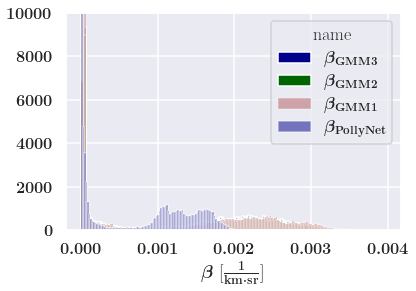

In [21]:
daily_beta_chan = daily_beta_chan.assign(beta_gmm1= beta_gmm1_da, beta_gmm2= beta_gmm2_da, beta_gmm3= beta_gmm3_da)
names= ['beta','beta_ratio','beta_gmm1','beta_gmm2','beta_gmm3']
labels = [r'$\beta$',r'$\beta_{\rm PollyNet}$',r'$\beta_{\rm GMM1}$',r'$\beta_{\rm GMM2}$',r'$\beta_{\rm GMM3}$']
height_slice_hist = slice(0,5)
fig, ax = plt.subplots(ncols=1, nrows=1)# figsize=(7, 5))
xr.plot.hist(daily_beta_chan[names[4]].clip(min=gs.eps).
             sel(Time=valid_times, Height=height_slice_hist, Wavelength= wavelength).drop('Wavelength'),
             ax=ax, bins=200)
xr.plot.hist(daily_beta_chan[names[3]].clip(min=gs.eps).
             sel(Time=valid_times, Height=height_slice_hist, Wavelength= wavelength).drop('Wavelength'),
             ax=ax, bins=200)
xr.plot.hist(daily_beta_chan[names[2]].clip(min=gs.eps).
             sel(Time=valid_times, Height=height_slice_hist, Wavelength= wavelength).drop('Wavelength'),
             ax=ax, bins=200, alpha =0.3)
xr.plot.hist(daily_beta_chan[names[1]].clip(min=gs.eps).
             sel(Time=valid_times, Height=height_slice_hist, Wavelength= wavelength).drop('Wavelength'),
             ax=ax, bins=200,alpha =0.5)

plt.legend(title='name', loc='best', labels=[labels[4],labels[3], labels[2], labels[1]])
ax.set_ylim([0,10000])

plt.show()

## Train models

In [22]:
TRAIN_MODEL=False
model_path = valid_utils.get_model_name(models_folder=models_folder,model_name_end=None)
if TRAIN_MODEL:
    gmm_params= {
    'n_components':50,
    'covariance_type':"full",
    'verbose':2,
    'random_state':42,
    'tol':0.0001,
    'reg_covar': 1e-7,
    'max_iter':1000,
    'n_init':2,
    'init_params':'k-means++'
    }
    db_name = 'initial' # 'initial/extended'
    samples = {'initial':samples_df.values, 'extended':samples_extend_df.values}[db_name]
    valid_utils.run(model_path=model_path, gmm_params=gmm_params, db_name=db_name, samples=samples)

Model name (get or create): /home/addalin/E/TGRS_GMM_appendix/models/sklearn_GMM_Model_1649_2406.pkl


In [23]:
model_path = valid_utils.get_model_name(models_folder=models_folder,model_name_end='2253_1206')
if TRAIN_MODEL:
    gmm_params= {
        'n_components':50,
        'covariance_type':"full",
        'verbose':2,
        'random_state':42,
        'tol':0.0001,
        'reg_covar': 1e-7,
        'max_iter':1000, # increase max_iter
        'n_init':1,
        'init_params':'k-means++'
        }
    db_name = 'initial' # 'initial/extended'
    samples = {'initial':samples_df.values, 'extended':samples_extend_df.values}[db_name]

    valid_utils.run(model_path=model_path, gmm_params=gmm_params, db_name=db_name, samples=samples)

Model name (get or create): /home/addalin/E/TGRS_GMM_appendix/models/sklearn_GMM_Model_2253_1206.pkl


In [24]:
model_path = valid_utils.get_model_name(models_folder=models_folder,model_name_end='2253_1206')
if TRAIN_MODEL:
    gmm_params= {
        'n_components':50,
        'covariance_type':"full",
        'verbose':2,
        'random_state':42,
        'tol':0.0001,
        'reg_covar': 1e-7,
        'max_iter':1000, # increase max_iter
        'n_init':1,
        'init_params':'k-means++'
        }
    db_name = 'extended' # 'initial/extended'
    samples = {'initial':samples_df.values, 'extended':samples_extend_df.values}[db_name]

    valid_utils.run(model_path=model_path, gmm_params=gmm_params, db_name=db_name, samples=samples)

Model name (get or create): /home/addalin/E/TGRS_GMM_appendix/models/sklearn_GMM_Model_2253_1206.pkl


In [25]:
model_path = valid_utils.get_model_name(models_folder=models_folder,model_name_end=None)
if TRAIN_MODEL:
    gmm_params= {
        'n_components':5,
        'covariance_type':"full",
        'verbose':2,
        'random_state':42,
        'tol':0.0001,
        'reg_covar': 1e-7,
        'max_iter':1000, # increase max_iter
        'n_init':10,
        'init_params':'k-means++'
        }
    db_name = 'initial' # 'initial/extended'
    samples = {'initial':samples_df.values, 'extended':samples_extend_df.values}[db_name]

    valid_utils.run(model_path=model_path, gmm_params=gmm_params, db_name=db_name, samples=samples)

Model name (get or create): /home/addalin/E/TGRS_GMM_appendix/models/sklearn_GMM_Model_1649_2406.pkl


In [26]:
model_path = valid_utils.get_model_name(models_folder=models_folder,model_name_end='2254_1306')
if TRAIN_MODEL:
    gmm_params= {
        'n_components':5,
        'covariance_type':"full",
        'verbose':2,
        'random_state':42,
        'tol':0.0001,
        'reg_covar': 1e-7,
        'max_iter':2000, # increase max_iter
        'n_init':1,
        'init_params':'k-means++'
        }
    db_name = 'extended' # 'initial/extended'
    samples = {'initial':samples_df.values, 'extended':samples_extend_df.values}[db_name]

    valid_utils.run(model_path=model_path, gmm_params=gmm_params, db_name=db_name, samples=samples)

Model name (get or create): /home/addalin/E/TGRS_GMM_appendix/models/sklearn_GMM_Model_2254_1306.pkl


## Plots
### Show $\beta$ and $\beta_{\rm GMM}$

Model name (get or create): /home/addalin/E/TGRS_GMM_appendix/models/sklearn_GMM_Model_0233_2106.pkl
Loading trained gmm model from /home/addalin/E/TGRS_GMM_appendix/models/sklearn_GMM_Model_0233_2106.pkl
BayesianGaussianMixture(init_params='k-means++', max_iter=1000, n_components=50,
                        random_state=42, reg_covar=1e-07, tol=0.0001, verbose=2,
                        warm_start=True)
calculate log-likelihood of gmm for the input grid
Elapsed time is 26.473622 seconds.
daily_beta_sklearn_GMM_Model_0233_2106


/home/addalin/learning_lidar/learning_lidar/generation/valid_utils.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


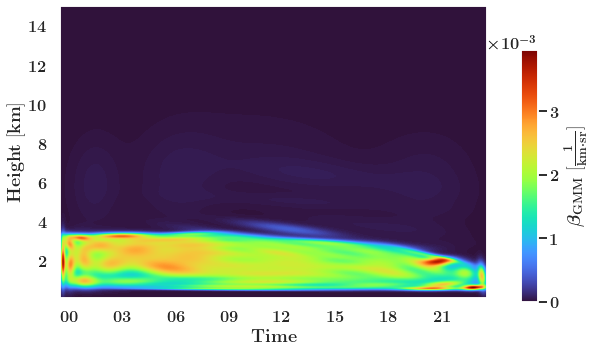

In [27]:
model_endings = ['0233_2106'] # earlier models of 50: '1301_1906' (init samples),'2253_1206' (extended samples first round), GMM31: '1214_0806'
betas = {}
betas['beta_ratio'] =  daily_beta_chan['beta_ratio']
models = {}
for model_ending in model_endings:

    model_name = valid_utils.get_model_name(models_folder=models_folder,model_name_end=model_ending)
    model = valid_utils.create_or_copy_model(model_path=model_name)
    models[model_ending] = model
    beta = valid_utils.calc_beta_from_gmm( gmm = model, gmm_name= model_ending, XY_grid= XYg_full,
                   orig_beta = daily_beta_chan.beta,
                   timeIndx= timeIndx, height_slice=height_slice,
                               wavelength=wavelength, scale_type='min_max')
    betas[model_ending] = beta
    fname = f"daily_beta_{(os.path.split(model_name)[1]).split('.pkl')[0]}"
    print(fname)
    valid_utils.plot_daily_profile_for_publish(beta.sel(Time= timeIndx),
                                   fname=fname, folder_name=figs_folder,
                                   height_slice=height_slice,
                                   figsize=figsize, save_fig=SAVE_FIG)


### Show how many gaussian used, according to their weights

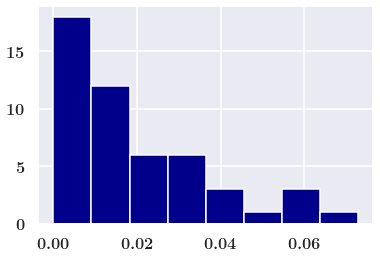

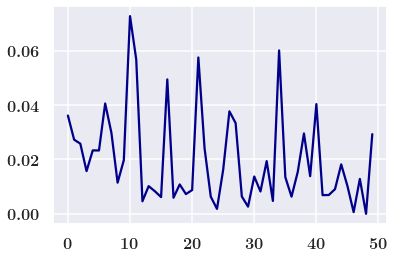

[18 12  6  6  3  1  3  1] [6.21066308e-08 9.09723121e-03 1.81944003e-02 2.72915694e-02
 3.63887385e-02 4.54859076e-02 5.45830768e-02 6.36802459e-02
 7.27774150e-02]
Number of Gaussians having weight lower than th=0.01 is 18
The total weight is 0.10
weights statistics:
(min,max)= (6.2e-08, 9.1e-03), 
(mean,std)= (5.6e-03, 2.6e-03)

Number of Gaussians having weight higher than th=0.01 is 32
The total weight is 0.90
weights statistics:
(min,max)= (1.0e-02, 7.3e-02), 
(mean,std)= (2.8e-02, 1.6e-02)


In [28]:
for modeln in model_endings:
    weights = models[modeln].weights_
    counts, bins = np.histogram(weights, bins=8)
    plt.hist(weights, bins=bins)
    plt.show()
    plt.plot(weights)
    plt.show()
    print(counts, bins)

th_w = 1e-2

low_weights = weights[weights< th_w]
high_weights = weights[weights>=th_w]
print(f"Number of Gaussians having weight lower than th={th_w} is {low_weights.shape[0]}\n"
      f"The total weight is {low_weights.sum():.2f}\n"
      f"weights statistics:\n(min,max)= ({low_weights.min():.1e}, {low_weights.max():.1e}), "
      f"\n(mean,std)= ({low_weights.mean():.1e}, {low_weights.std():.1e})\n")
print(f"Number of Gaussians having weight higher than th={th_w} is {high_weights.shape[0]}\n"
      f"The total weight is {high_weights.sum():.2f}\n"
      f"weights statistics:\n(min,max)= ({high_weights.min():.1e}, {high_weights.max():.1e}), "
      f"\n(mean,std)= ({high_weights.mean():.1e}, {high_weights.std():.1e})")


## Comparison between $\rho_s^{\rm Polly}$ and $\rho_s^{\rm GMM}$

/tmp/ipykernel_234930/796053075.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_samples_model = model_samples_df[model_samples_df.x>min_x][model_samples_df.x<max_x][model_samples_df.y>min_y][model_samples_df.y<max_y]
/home/addalin/learning_lidar/learning_lidar/generation/valid_utils.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


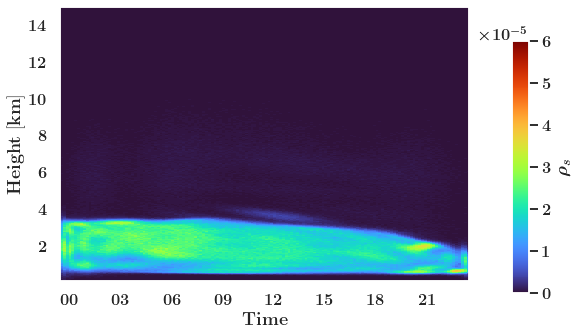

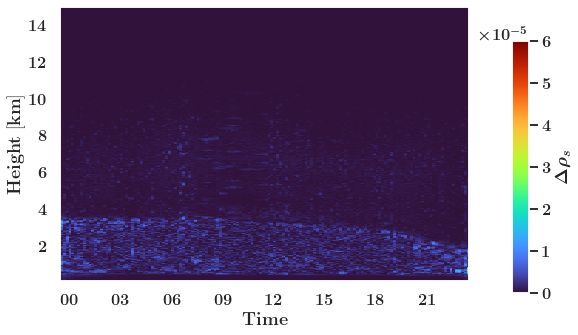

Global NRMSE :0.1303
Absolute diff mean: 1.17e-06, max:4.08e-05, min: 0.00e+00


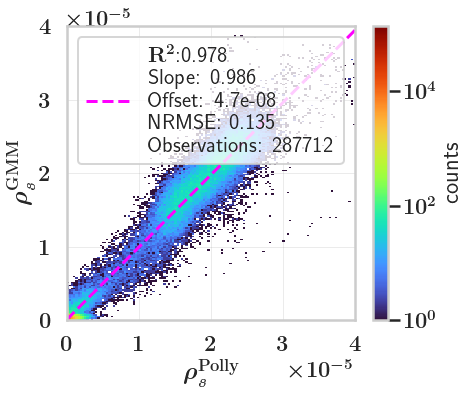

In [29]:
n_samples_cmpr = samples_extend_df.shape[0]
n_samples_model = n_samples_cmpr*2
sns.set_context('talk')

for model_uname in model_endings:

    model_samples, _ = models[model_uname].sample(n_samples_model)

    # take only valid samples on the space-time domain
    model_samples_df = pd.DataFrame(data=model_samples, columns=['x','y'])
    min_y, max_y =  y.min(), max_height
    min_x, max_x = x_full.min(), x_full.max()
    valid_samples_model = model_samples_df[model_samples_df.x>min_x][model_samples_df.x<max_x][model_samples_df.y>min_y][model_samples_df.y<max_y]

    # plot histogram
    hist_2D_model, (H, yedges, xedges)= valid_utils.calc_2D_hist(XY_grid = XYg_samp,sample_source_name=f"GMM model {model_uname}",
                                samples_df=valid_samples_model,norm_hist=True,
                                    weights= interp_beta.sel(Time=time_intep_sample,Height= height_slice))
    valid_utils.plot_daily_profile_for_publish(hist_2D_model, figsize=figsize, folder_name=figs_folder, save_fig=SAVE_FIG, threshold= 6e-5, format_fig='svg')
    da_diff = xr.apply_ufunc(lambda x,y: np.abs(x-y),hist_2D_more,hist_2D_model , keep_attrs=True)
    da_diff.attrs = {'name': 'Global error of normalized distributions','long_name':r'$\Delta \rho_s$',
                                   'info':rf"Difference of 2D distributions"}
    da_diff_norm = xr.apply_ufunc(lambda dif,y: dif/(np.abs(y)+gs.eps), da_diff, hist_2D_more, keep_attrs=True) #np.sqrt((dif**2)/(y**2+gs.eps))
    da_diff_norm.attrs = {'name': 'Local error of normalized distributions','long_name':r'$\epsilon \rho_s$',
                                   'info':rf"Normalized differences of 2D distributions"}

    valid_utils.plot_daily_profile_for_publish(da_diff, figsize=figsize, folder_name=figs_folder, save_fig=SAVE_FIG, threshold= 6e-5, format_fig='svg')
    # plot_daily_profile_for_Opex(da_diff_norm.where(da_diff_norm<0.1),figsize=(12,5),folder_name=figs_folder,save_fig=SAVE_FIG)
    nrmse = np.linalg.norm(da_diff.sel(Height=slice(0,5)))/np.linalg.norm(hist_2D.sel(Height=slice(0,5)))
    epsilon = np.mean(da_diff_norm.sel(Height=slice(0,4.5))).values
    print(f'Global NRMSE :{nrmse:.4f}')

    abs_vals = np.abs(da_diff.sel(Height=slice(0,5)).values)
    print(f'Absolute diff mean: {np.mean(abs_vals):.2e}, max:{np.max(abs_vals):.2e}, min: {np.min(abs_vals):.2e}')
    fig_path, fig, ax = valid_utils.plot_regression(source_vals= hist_2D_more.sel(Height=slice(0,15)).values.ravel(),
                                    pred_vals= hist_2D_model.sel(Height=slice(0,15)).values.ravel(),
                                    title_source=r'$\rho_s^{\rm Polly}$',
                                    title_pred=r'$\rho_s^{\rm GMM}$',
                    figsize=(7,6),fname='Linear regression scatter plot',folder_name= figs_folder,
                    max_val= 4e-5,
                    save_fig=True,format_fig='svg')


### Compare histograms of $\rho_s^{\rm Polly}$ vs. $\rho_s^{\rm GMM}$

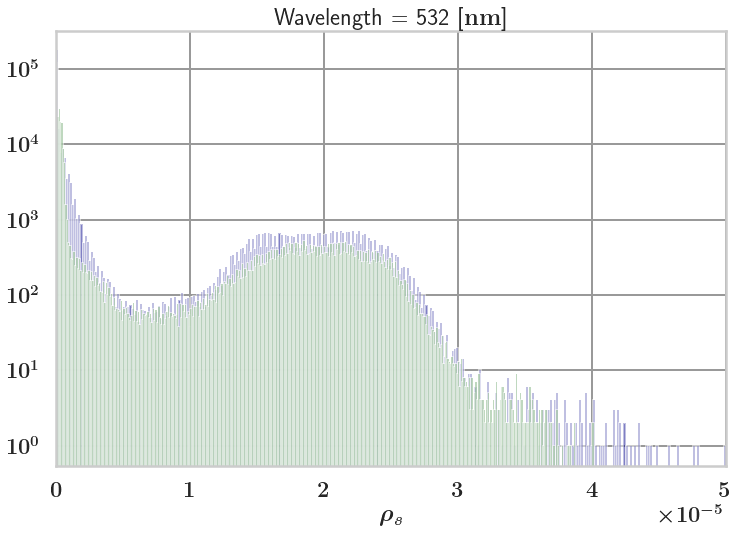

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12, 8))
xr.plot.hist(hist_2D_more,ax=ax, bins=400, alpha =0.5)
xr.plot.hist(hist_2D_model,ax=ax, bins=400, alpha =0.5)
ax.set_yscale('log')
ax.set_xlim([0,5e-5])
plt.show()

dict_keys(['beta_ratio', '0233_2106'])


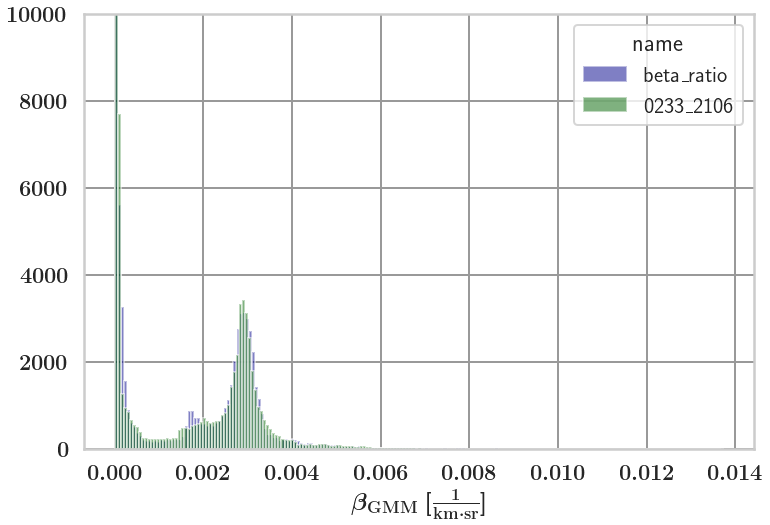

In [31]:
beta_names =betas.keys()# ['beta_ratio', '2253_1206', 'gmm3']
print(beta_names)
height_slice_hist = slice(0,5)

fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12, 8))
# for _, beta in betas.items():
labels = []
for name in list(beta_names):
    cur_beta = betas[name].clip(min=gs.eps).sel(Time=valid_times, Height=height_slice_hist, Wavelength= wavelength).drop('Wavelength')
    norm_beta = xr.apply_ufunc(lambda x: x/(sum(x)), cur_beta, keep_attrs=True)

    labels.append(name)
    # beta_norm_factor*proc_utils.normalize(Z.copy())
    xr.plot.hist(norm_beta,ax=ax, bins=200, alpha =0.5)

plt.legend(title='name', loc='best', labels=labels)
ax.set_ylim([0,10000])

plt.show()


### Kolmogorov-Smirnov test (1D)

In [32]:
beta_ratio_hist, _ = np.histogram(xr.apply_ufunc(lambda x: x/(sum(x)), betas['beta_ratio'].clip(min=gs.eps). #x/(sum(x))
                 sel(Time=valid_times, Height=height_slice_hist, Wavelength= wavelength), keep_attrs=True).
                                  drop('Wavelength').values.flatten(), bins=200)

beta_model_hist, _ = np.histogram(xr.apply_ufunc(lambda x: x/(sum(x)), betas['0233_2106'].clip(min=gs.eps). #x/(sum(x))
                 sel(Time=valid_times, Height=height_slice_hist, Wavelength= wavelength), keep_attrs=True).
                                  drop('Wavelength').values.flatten(), bins=200)

ks_2samp(beta_model_hist, beta_ratio_hist)

KstestResult(statistic=0.07, pvalue=0.7125821300149116)

In [33]:
len(time_intep_sample), len(y),len(time_intep_sample)*len(y) , len(time_intep_sample)*len(y)*10, len(time_intep_sample)*len(y)*60


(144, 1998, 287712, 2877120, 17262720)

### Kolmogorov-Smirnov test (2D)

In [34]:
valid_utils.ks2d2s(x1=model_samples[:n_samples_cmpr,0], y1=model_samples[:n_samples_cmpr,1],
       x2=samples[:n_samples_cmpr,0], y2=samples[:n_samples_cmpr,1],
       extra=True)

InvalidIndexError: (slice(None, 17262720, None), 0)